In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from evaluate_sentiment import Evaluator
np.random.seed(42)
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
%load_ext autoreload
%autoreload 2

# Data Exploration

In [2]:
data_root=Path("../data/Hebrew-Sentiment-Data/Sentiment_Data")
token_folder=data_root/"token"
morph_folder=data_root/"morph"
# train_path=token_folder/"train.tsv"
# test_path=token_folder/"test_gold.tsv"
train_path=morph_folder/"train.tsv"
test_path=morph_folder/"test_gold.tsv"
train_df=pd.read_csv(train_path, encoding="utf-8", sep="\t")
train_df.loc[:, "label"]=train_df.label.astype("category")
test_df=pd.read_csv(test_path, encoding="utf-8", sep="\t")
test_df.loc[:, "label"]=test_df.label.astype("category")
text=train_df["comment"]
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5932 entries, 0 to 5931
Data columns (total 2 columns):
comment    5932 non-null object
label      5932 non-null category
dtypes: category(1), object(1)
memory usage: 52.4+ KB
None


In [68]:
print(train_df.query("label==2").head())

                                               comment label
47   חייבים לעשות סוג של חרם כש כתבים שונאי ישראל ע...     2
69   אז אתה בא ? https://www.facebook.com/events/15...     2
73    גאי אתה טיפש מטופש ילד כאפות ש לא חונך על ברכ...     2
105  ש מעון יפרח העלאתי בשביל אתה את דבריו של שמעון...     2
168  רובי ריבלין ה נשיא ה עשירי תחזית ש ניתנה לפני ...     2


0    4024
1    1744
2     164
Name: label, dtype: int64
0    0.678355
1    0.293999
2    0.027647
Name: label, dtype: float64


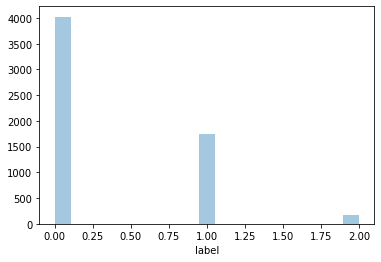

In [3]:
tot=len(train_df)
print(train_df.label.value_counts())
print(train_df.label.value_counts()/tot)
sns.distplot(train_df.label, kde=False)

In [32]:
count_vect = CountVectorizer(ngram_range=(1,2))
X_train_counts = count_vect.fit_transform(train_df.comment)
X_train_counts.shape

(5932, 88276)

In [33]:
X_test_counts = count_vect.transform(test_df.comment)
X_test_counts.shape

(1696, 88276)

In [34]:
count_vect.vocabulary_.get('רובי')

78195

In [35]:
count_vect.vocabulary_.get('או')

2704

In [36]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(5932, 88276)

In [37]:
# X_test_tfidf = tf_transformer.transform(X_test_counts)

# Benchmarks

In [38]:
evaluator=Evaluator()

test_df has 1696 rows


# Simplest - majority classifier

In [39]:
predicted_maj = len(test_df)*[0]
print(len(test_df))
evaluator.evaluate(predicted_maj)

1696
Micro precision:0.7871462264150944, recall:0.7871462264150944, f1:0.7871462264150944
Macro precision:0.2623820754716981, recall:0.3333333333333333, f1:0.2936324645331574
Accuracy: 0.7871462264150944
[[1335    0    0]
 [ 316    0    0]
 [  45    0    0]]


C:\Users\fyuva\Anaconda3\envs\hebnlp\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Throw a die classifier

In [40]:
def get_die_value():
    cur_val=np.random.rand()
    if cur_val<0.66:
        return 0
    elif cur_val<0.96:
        return 1
    else:
        return 2

In [43]:
die_predicted=[get_die_value() for _ in range(len(test_df))]
print(die_predicted[:10])

[1, 0, 1, 0, 0, 1, 1, 1, 0, 1]


In [44]:
evaluator.evaluate(die_predicted)

Micro precision:0.5754716981132075, recall:0.5754716981132075, f1:0.5754716981132075
Macro precision:0.33140398122185705, recall:0.33128078298751035, f1:0.32511893176563395
Accuracy: 0.5754716981132075
[[883 386  66]
 [214  91  11]
 [ 31  12   2]]


In [45]:
def get_hebrew_stopwords():
    stop_path="../data/heb_stopwords.txt"
    with open(stop_path, encoding="utf-8") as in_file:
        lines=in_file.readlines()
        res=[l.strip() for l in lines]
        print(res[:4])
    return res

In [71]:
"""
basic pipe:
a. whitespace
b. remove stopwords
c. unigrams
d. no tf/idf
e. no feature selection
f. naive bayes
"""
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

heb_stop_words=get_hebrew_stopwords()
#count_vectorizer=CountVectorizer(stop_words=heb_stop_words)
count_vectorizer=CountVectorizer(ngram_range=(1,2))
transformer=TfidfTransformer()
algo=LogisticRegression()
pipe = Pipeline([('vectorizer', count_vectorizer),
                 ('transformer', transformer),
                 #('feature_select', SelectKBest(chi2, k=20000)),
                 ('algo', algo)])
pipe.fit(train_df.comment, train_df.label)
predicted = pipe.predict(test_df.comment)
evaluator.evaluate(predicted)
evaluator.show_errors(predicted, 10,1)

['את', 'לא', 'של', 'אני']
Micro precision:0.8714622641509434, recall:0.8714622641509434, f1:0.8714622641509434
Macro precision:0.8673749741928312, recall:0.565948945674447, f1:0.5893603592085568
Accuracy: 0.8714622641509434
[[1265   70    0]
 [ 107  209    0]
 [  18   23    4]]
overall, there are 70 instances with wrong sentiment
גם לא ל ה אולמרט ו שאר ה מושחתים ., true:0, predicted:1

 יהודי , זה מיגבן רב של אנשים , ש קוראים ל אצמם יהודים , ו הם יהודים טובים , ישראלים טובים , אוהאבי ישדאל ו ה עם ה יהודי , אוהבי ה מדינה ש הם חיים ב היא , ו זה לא עומר ש הם חייבים לשאת 24 שעות ב יממה את את ה מחשבה ש הם בני ישראל ש יצאו מ מיצרים ו זה לא עומר ש הם חייבים ל ימחוק כול מי ש חושב אחרת . ב ארצות חוץ ל ה ארץ אנחנו מבקשים זכויות שוות , ל ה יהודים , ו מקבלים את הם . ה אמונה צריכה ל יהיות ב ליבינו , ו להתנהג ב ה חברה כ בן אנוש . אם ה אמונה חזקה , ו אם אנחנו בני אנוש , של שנות 2000 , שום דבר לא יכול ל יבגוע , או להרוס את ה אמונה ה יהודית . , true:0, predicted:1

 תביא שלום ו מהר בלי תירוצים . זה מה 

# Naive Bayes Classifier

In [72]:
evaluator.show_errors(predicted, 10,1)

overall, there are 107 instances with wrong sentiment
 עד מתי , ה לב קרוע על ה ילדים , ו ה משפחות , !!!!!!!!!! , true:1, predicted:0

 אכן , בין בוגרי ה פקולטה ה נ"ל אנשים ש עיצבו את אמות ה מידה ה ציבוריות ב ה ארץ . למשל , היה שם איזה אחד , אולי שמעתם על הוא , קוראים ל הוא אהוד אולמרט ... , true:1, predicted:0

 אם זוהי דמותו של נשיא מדינת ישראל ( ??? ) אז אפשר לומר ש היא די עלובה ... אדם חסר עמוד שידרה ו גאווה ב יהדותו ו מוצאו , עוד ענף תלוש ה מצטרף לאותם יפי ( חולי ) נפש . , true:1, predicted:0

תודה ל אתה נשיאנו על ה חיזוק ל התבוללות ו ניתוק מ ה שורשים עכשיו אני מבין למה ביבי לא רצה ב אתה . הוא מכיר את אתה יותר טוב מ אזרחי ה מדיה, true:1, predicted:0

 ל שלושת ה משפחות נותר חלל ב ליבם , ו כך גם ל כל עם ישראל . , true:1, predicted:0

תעשה ל אני טובה אל תגרום לקלל את אתה אז עדיף ש תסתום, true:1, predicted:0

נשיא-רובי ראש מ משלה-ביבי אופוזיציה - בוז ׳ י ביטחון - בוגי יו ״ ר כנסת - יורי ו כולם שמים על אנחנו - זובי !, true:1, predicted:0

אויש נו . אל תהיו תמימים ., true:1, predicted:0


In [56]:
maprint(pipe["algo"].coef_)

[[-0.20445617 -0.17885735 -0.08121911 ... -0.09968619 -0.05270076
  -0.05270076]
 [ 0.131126    0.09055906  0.08997523 ...  0.10846646 -0.04816097
  -0.04816097]
 [ 0.07333017  0.08829829 -0.00875612 ... -0.00878027  0.10086173
   0.10086173]]


In [57]:
inverse_dict={count_vect.vocabulary_[w]:w for w in count_vect.vocabulary_.keys()}
print(inverse_dict[0])
print(inverse_dict[7111])

00
אלימות


In [58]:
def get_strongest_words(label):
    cur_coef=pipe["algo"].coef_[label]
    word_df=pd.DataFrame({"val":cur_coef}).reset_index().sort_values(["val"],ascending=[False])
    word_df.loc[:, "word"]=word_df["index"].apply(lambda v:inverse_dict[v])
    print(word_df.head(10))

In [ ]:

clf = MultinomialNB().fit(X_train_tf, train_df.label)

In [ ]:
predicted = clf.predict(X_test_tfidf)

In [ ]:
print(predicted[:5])

In [ ]:
evaluator.evaluate(predicted)

# Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression().fit(X_train_tf, train_df.label)

In [ ]:
logistic_predicted=clf.predict(X_test_tfidf)
evaluator.evaluate(logistic_predicted)

In [ ]:
evaluator.show_errors(logistic_predicted, 10)

In [ ]:
print(clf.coef_)

In [ ]:
inverse_dict={count_vect.vocabulary_[w]:w for w in count_vect.vocabulary_.keys()}
print(inverse_dict[0])
print(inverse_dict[7111])

In [ ]:
def get_strongest_words(label):
    cur_coef=clf.coef_[label]
    word_df=pd.DataFrame({"val":cur_coef}).reset_index().sort_values(["val"],ascending=[False])
    word_df.loc[:, "word"]=word_df["index"].apply(lambda v:inverse_dict[v])
    print(word_df.head(10))

In [63]:
get_strongest_words(0)

       index       val   word
25857  25857  4.671619  הצלחה
65087  65087  2.265333   נשיא
45886  45886  2.105294     לב
40645  40645  1.959779   כבוד
6078    6078  1.906511    איש
7766    7766  1.839619    אמן
85054  85054  1.836667   תודה
77230  77230  1.830808   ראוי
2242    2242  1.772221    אדם
82409  82409  1.608058   שלום


In [64]:
get_strongest_words(1)

       index       val      word
44436  44436  3.361517        לא
26782  26782  3.152505  התבוללות
52875  52875  2.351035        מה
34700  34700  2.306299     יהודי
71542  71542  2.135128     ערבים
14009  14009  2.043635      בושה
71376  71376  1.950154      ערבי
35039  35039  1.718142    יהודים
27996  27996  1.670672        זה
88032  88032  1.558756    תתבייש


In [65]:
get_strongest_words(2)

       index       val          word
17311  17311  1.908261           גאי
1504    1504  1.806050           www
806      806  1.647688           com
1010    1010  1.413700         https
1012    1012  1.311112     https www
839      839  1.139920            d7
913      913  0.956254  facebook com
912      912  0.956254      facebook
56700  56700  0.859743      ממאריבור
6496    6496  0.859743           אכי


In [ ]:
count_vect = CountVectorizer(ngram_range=(1,2))
X_train_counts = count_vect.fit_transform(train_df.comment)
X_train_counts.shape

In [ ]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

In [ ]:
X_test_counts = count_vect.transform(test_df.comment)
X_test_counts.shape

In [ ]:
X_test_tfidf = tf_transformer.transform(X_test_counts)

In [ ]:
clf=LogisticRegression().fit(X_train_tf, train_df.label)

In [ ]:
logistic_predicted=clf.predict(X_test_tfidf)
evaluator.evaluate(logistic_predicted)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X_new = SelectKBest(chi2, k=10000).fit_transform(X_train_tf, train_df.label)
print(X_new.shape)
clf=LogisticRegression().fit(X_new, train_df.label)


# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier().fit(X_train_tf, train_df.label)


In [ ]:
rf_prediction=clf.predict(X_test_tfidf)
evaluator.evaluate(rf_prediction)

# Once again, with bigrams